In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
import ipywidgets
import warnings
warnings.filterwarnings('ignore')

# Import linear regression model
from sklearn.linear_model import LinearRegression
# Min max scaler
from sklearn.preprocessing import MinMaxScaler


def mlp(r_i, r_d, N_i, N_h, N_o, training_steps=5000, lr=0.7, batch_size=1):

    # Initialize randomly the weights
    # Hidden layer
    w_h = np.random.rand(N_h+1,N_i) - 0.5
    # Output layer
    w_o=np.random.rand(N_o,N_h+1) - 0.5

    mse = []

    for ti in range(training_steps):
        # Select training pattern randomly
        #i = np.floor(4*np.random.rand()).astype('int')
        for bi in range(batch_size):
            # Feed-forward the input to hidden layer
            i = np.floor(np.shape(r_i)[1]*np.random.rand()).astype('int')
            r_h = 1 / (1 + np.exp(-w_h*r_i[:,i]))
            r_h[-1] = 1  # Bias from hidden to output layer
            #r_h = np.concatenate((r_h, np.ones((1,1))), axis=0)
            # Feed-forward the input to the output layer
            r_o = 1 / (1 + np.exp(-w_o*r_h))
            # Calculate the network error
            d_o = np.multiply(np.multiply(r_o, 1-r_o), r_d[:,i] - r_o)
            # Calculate the responsability of the hidden network in the error
            d_h = np.multiply(np.multiply(r_h, (1-r_h)), (w_o.T*d_o))
            # Update weights
            w_o = w_o + lr*(r_h*d_o.T).T
            w_h = w_h + lr*(r_i[:,i]*d_h.T).T
            
        # Test all patterns
        #r_o_test = 1 / (1 + np.exp(-w_o*(1/(1+np.exp(-w_h*r_i)))))
        rht = 1 / (1 + np.exp(-w_h*r_i))
        rht[-1] = 1
        r_o_test = 1 / (1 + np.exp(-w_o*rht))
        mse += [mean_squared_error(np.array(r_d), np.array(r_o_test))]
        
    return mse, r_o_test, w_h, w_o

def mlp_predict(r_i, w_h, w_o):
    # Test all patterns
    #r_o_test = 1 / (1 + np.exp(-w_o*(1/(1+np.exp(-w_h*r_i)))))
    rht = 1 / (1 + np.exp(-w_h*r_i))
    rht[-1] = 1
    r_o_test = 1 / (1 + np.exp(-w_o*rht))
    return r_o_test

x = np.array([63, 64, 66, 69, 69, 71, 71, 72, 73, 75])

y = np.array([127, 121, 142, 157, 162, 156, 169, 165, 181, 208])

@ipywidgets.interact
def plot(N_h = [2, 10, 20, 30, 40, 50, 100, 500],
         epochs=[1000, 5000, 10000],
         cut=['(0,1)', '(0.05,0.95)', '(0.1,0.9)']
        ):
    feature_ranges = {'(0,1)': (0,1), '(0.05,0.95)': (0.05,0.95), 
                      '(0.1,0.9)': (0.1,0.9)}
    xs = (x - x.min()) / (x.max() - x.min())  # min max scale the x vector
    # The ones are the bias 
    X_train = np.concatenate((xs.reshape(-1,1), np.ones((len(x),1))), axis=1)  # This is the input scaled
    x_in = np.matrix(X_train.transpose())  # X train
    scaler = MinMaxScaler(feature_range=feature_ranges[cut])  # min max scale y
    scaler.fit(y.reshape(-1, 1))  # fit scaler
    x_out = np.matrix(scaler.transform(y.reshape(-1, 1)).T)  # shape need for calling mlp
    
    # The output layer size is 1
    N_i = 2; N_o = 1 

    # Fit the model
    result = mlp(x_in, x_out, N_i, N_h, N_o, training_steps=epochs, lr=0.8, batch_size=10)
    
    # Build a decision curve between 50 and 100 for X
    x_test = np.linspace(50, 100)
    x_test_scaled = (x_test - x.min()) / (x.max() - x.min())  # scale input for decision curve
    x_i_test = np.concatenate((x_test_scaled.reshape(-1,1), np.ones((len(x_test_scaled),1))), axis=1)
    y_test = mlp_predict(x_i_test.transpose(), result[2], result[3])  # call your model
    
    # trasform output to original scale
    a, b = y.min(), y.max()  
    y_orig_scale = np.array(y_test).flatten()*(b-a) + a
    
    y_mlp = np.array(result[1]).flatten()  # this is y_output for X_train
    y_mlp = y_mlp*(b-a) + a  # transform to original scale
    
    # Instance model
    lin_reg = LinearRegression()
    # Fit model (train)
    lin_reg.fit(x.reshape(-1,1),y)  # our lineal model (base model)
    y_lin_reg = lin_reg.coef_*x + lin_reg.intercept_
    y_lr_test = lin_reg.coef_*x_test + lin_reg.intercept_  # test unseen data

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.scatter(x, y)
    plt.plot(x_test, y_orig_scale, '--g', label='MLP')
    plt.plot(x_test, y_lr_test, ':r', label='Curve fit')
    plt.xlim(x.min()-0.1, x.max()+0.1)
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(x, y)
    plt.plot(x_test, y_orig_scale, '--g', label='MLP')
    plt.plot(x_test, y_lr_test, ':r', label='Curve fit')
    plt.legend()
    print("MSE (linreg):", mean_squared_error(y, y_lin_reg))
    print("MSE (MLP):", mean_squared_error(y, y_mlp))

interactive(children=(Dropdown(description='N_h', options=(2, 10, 20, 30, 40, 50, 100, 500), value=2), Dropdow…

In [15]:
from sklearn.neural_network import MLPRegressor

@ipywidgets.interact
def plot(N_h = [10, 50, 100, 500, 1000],
         zoom=False,
        ):
    mlpreg = MLPRegressor(activation='relu',max_iter=10000,hidden_layer_sizes=(N_h,))
    x_scaled = (x - x.min()) / (x.max() - x.min())
    mlpreg.fit(x_scaled.reshape(-1,1),y)
    x_test = np.linspace(50, 100)
    x_test_scaled = (x_test - x.min()) / (x.max() - x.min())
    y_mlp = mlpreg.predict(x_test_scaled.reshape(-1, 1))
    plt.scatter(x, y, label='Data')
    plt.plot(x_test, y_mlp, '--r', label='MLP')
    # Instance model
    lin_reg = LinearRegression()
    # Fit model (train)
    lin_reg.fit(x.reshape(-1,1),y)  # our lineal model (base model)
    y_lr_test = lin_reg.coef_*x_test + lin_reg.intercept_
    plt.plot(x_test, y_lr_test, ':g', label='LR')
    l=plt.legend()
    if zoom:
        plt.xlim(x.min(), x.max())

interactive(children=(Dropdown(description='N_h', options=(10, 50, 100, 500, 1000), value=10), Checkbox(value=…

### Step by step implementation

Find a function $f$, such that it maps an input $X$ to an output $y$:

$$y=f(X)$$

Where $y \in \mathbb{R}$ is a continuous variable.

$f:=MLP\_predict(X_{in}, W_l)$, $f:= \sum_i a_i x_i + b$

- Summary of the process:
  - Min max scale input (**x_in**)  and output (**x_out**):
```Python
xs = (x - x.min()) / (x.max() - x.min())  # min max scale the x vector
X_train = np.concatenate((xs.reshape(-1,1), np.ones((len(x),1))), axis=1)  # This is the input scaled
x_in = np.matrix(X_train.transpose())  # X train
scaler = MinMaxScaler(feature_range=feature_ranges[cut])  # min max scale y
scaler.fit(y.reshape(-1, 1))  # fit scaler
x_out = np.matrix(scaler.transform(y.reshape(-1, 1)).T)  # shape need for calling mlp
```

  - Min max scaler

<img src="https://i.stack.imgur.com/EuitP.png" alt="minmax" style="width:20%">

- Neural network architecture:

  - For our particular problem, a simple regression, $y=f(X)$, where $X$ is univariate.
    - The input layer is composed of a single vector $X_1$
  - The 1 vector corresponds to the bias. 
  - The output is of size 1, just one neuron (for the regression problem). 
    - Note that the activiation function in our MLP is logistic. So we scale the output between 0 and 1.
  
<img src="https://raw.githubusercontent.com/marsgr6/r-scripts/master/imgs/mlp_reg.jpeg" alt="minmax" style="width:40%">

- Output and test of the model
  - Check in the code that the model is tested outside the limits of the training set. 
  - This the decision curve of the model.
    - Not good outside the limits (answer why). 
    - Test the number of hidden neurons and identify an overfitted model.
  - The model is compared with a base linear model. 

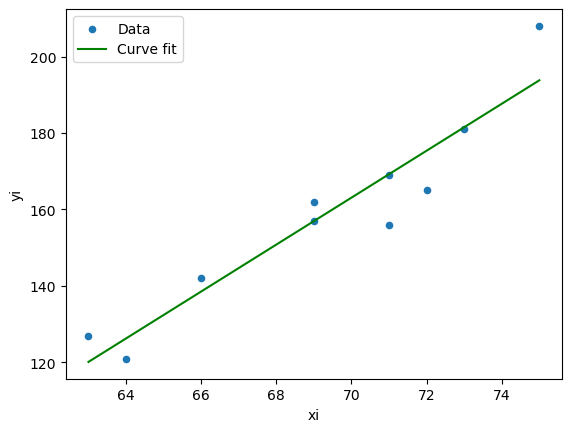

In [9]:
import pandas as pd
x = [63, 64, 66, 69, 69, 71, 71, 72, 73, 75]
x = np.array(x)

y = [127, 121, 142, 157, 162, 156, 169, 165, 181, 208]
y = np.array(y)

data = pd.DataFrame({'xi': x, 'yi': y})

data.plot.scatter('xi', 'yi', label="Data")

# Instance model
lin_reg = LinearRegression()
# Fit model (train)
lin_reg.fit(x.reshape(-1,1),y)

y_lin_reg = lin_reg.coef_*x + lin_reg.intercept_
plt.plot(x, y_lin_reg, 'g', label='Curve fit')
plt.legend()

In [26]:
X_train = np.concatenate((x.reshape(-1,1), np.ones((len(x),1))), axis=1)  # The ones are the bias 
X_train

array([[63.,  1.],
       [64.,  1.],
       [66.,  1.],
       [69.,  1.],
       [69.,  1.],
       [71.,  1.],
       [71.,  1.],
       [72.,  1.],
       [73.,  1.],
       [75.,  1.]])

In [39]:
xs = (x - x.min()) / (x.max() - x.min())
X_train = np.concatenate((xs.reshape(-1,1), np.ones((len(x),1))), axis=1)  # This is the input scaled
r_i = np.matrix(X_train.transpose())  # X
r_d = np.matrix(y.transpose())  # y
scaler = MinMaxScaler()
scaler.fit(y.reshape(-1, 1))
r_d = np.matrix(scaler.transform(y.reshape(-1, 1)).T)
X_train, r_d

(array([[0.        , 1.        ],
        [0.08333333, 1.        ],
        [0.25      , 1.        ],
        [0.5       , 1.        ],
        [0.5       , 1.        ],
        [0.66666667, 1.        ],
        [0.66666667, 1.        ],
        [0.75      , 1.        ],
        [0.83333333, 1.        ],
        [1.        , 1.        ]]),
 matrix([[0.06896552, 0.        , 0.24137931, 0.4137931 , 0.47126437,
          0.40229885, 0.55172414, 0.50574713, 0.68965517, 1.        ]]))

### Scale the data

- Min max scaler

<img src="https://i.stack.imgur.com/EuitP.png" alt="minmax" style="width:30%">

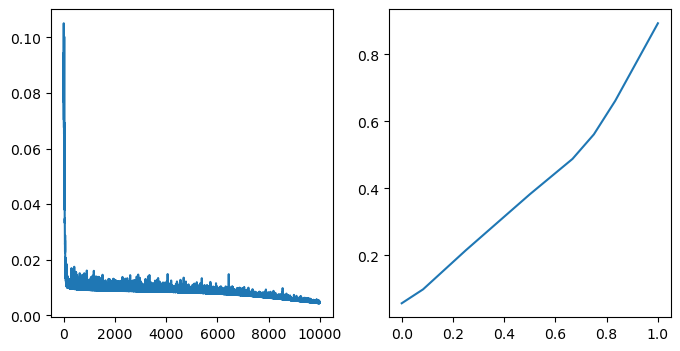

In [67]:
N_i = 2; N_h = 10; N_o = 1 

result = mlp(r_i, r_d, N_i, N_h, N_o, training_steps=10000, lr=0.8, batch_size=10)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(result[0])
plt.subplot(1,2,2)
plt.plot(xs, np.array(result[1]).flatten())

In [68]:
def mlp_predict(r_i, w_h, w_o):
    # Test all patterns
    #r_o_test = 1 / (1 + np.exp(-w_o*(1/(1+np.exp(-w_h*r_i)))))
    rht = 1 / (1 + np.exp(-w_h*r_i))
    rht[-1] = 1
    r_o_test = 1 / (1 + np.exp(-w_o*rht))
    return r_o_test

In [77]:
x_test = np.linspace(50, 100)
x_test_scaled = (x_test - x.min()) / (x.max() - x.min())
r_i_test = np.concatenate((x_test_scaled.reshape(-1,1), np.ones((len(x_test_scaled),1))), axis=1)
y_test = mlp_predict(r_i_test.transpose(), result[2], result[3])

In [82]:
a, b = y.min(), y.max()
y_orig_scale = np.array(y_test).flatten()*(b-a) + a

In [94]:
y_mlp = np.array(result[1]).flatten()
y_mlp = y_mlp*(b-a) + a

array([125.93755274, 129.55376466, 139.68826183, 154.23767472,
       154.23767472, 163.4323402 , 163.4323402 , 169.79942307,
       178.50674123, 198.65157859])

MSE (linreg): 59.738595220854634
MSE (MLP): 35.04062525627255


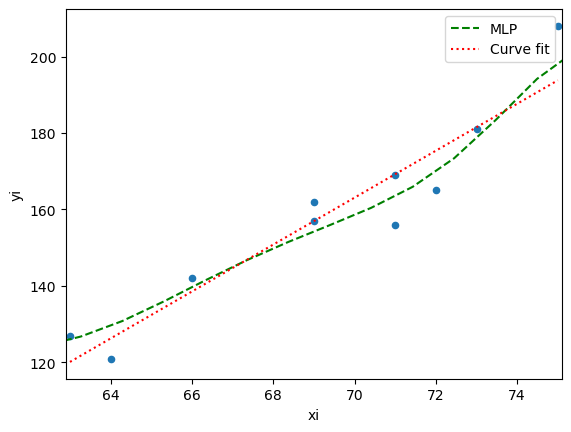

In [101]:
data.plot.scatter('xi', 'yi')
plt.plot(x_test, y_orig_scale, '--g', label='MLP')
plt.plot(x, y_lin_reg, ':r', label='Curve fit')
plt.xlim(x.min()-0.1, x.max()+0.1)
plt.legend()
print("MSE (linreg):", mean_squared_error(y, y_lin_reg))
print("MSE (MLP):", mean_squared_error(y, y_mlp))

Research: 
- Wich metrics are used to evaluate a regression model: https://machinelearningmastery.com/regression-metrics-for-machine-learning/
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

Sources: 
  - https://www.kaggle.com/code/androbomb/simple-nn-with-python-multi-layer-perceptron
  - https://web.cs.dal.ca/~tt/fundamentals/programs/Octave/Chapter6/
  - https://www.mathworks.com/academia/books/fundamentals-of-computational-neuroscience-trappenberg.html

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cce3455d-da08-4c10-a6fe-39f2a30c6a51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>